## 1. Import packages and read in data

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import collections
import pickle
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
proj_path = "/Users/jdjumalieva/Documents/Analysis/weight_loss_modelling/"

#### Read in inputs

In [4]:
# Read in HSE sample data
hse = pd.read_csv(
    os.path.join(proj_path, "calorie_deficit_scenarios_w_imd.csv"), index_col=0
)

In [5]:
hse.columns

Index(['Sex', 'Age_group', 'Age_est', 'Ethnicity', 'BMI_class',
       'sample_weight', 'BMI_est', 'Wt_est', 'Ht_est', 'IMD_q', 'marstatD',
       'tenureb', 'HHINC3', 'Activb2', 'HRPSOC10B', 'GOR1', 'topqual3',
       'hpnssec8'],
      dtype='object')

In [6]:
hse.loc[10292] # cross checking that dataframe index corresponds to 'X' column in the processed file

Sex                 female
Age_group            30-34
Age_est                 32
Ethnicity            White
BMI_class            obese
sample_weight     1.143296
BMI_est          30.865052
Wt_est                89.2
Ht_est               170.0
IMD_q                    1
marstatD                 2
tenureb                  4
HHINC3                  -1
Activb2                  2
HRPSOC10B               11
GOR1                     7
topqual3                 3
hpnssec8                 1
Name: 10292, dtype: object

In [7]:
# Read in results from running scenario 2 (proportional reduction for all overvweight and obese individuals over
# 3 years)
# In hse_modelling_3years_XXpercent.csv files, only obese and overweight people are included

sc_10p = pd.read_csv(os.path.join(proj_path, "hse_modelling_3years_10percent.csv"))
sc_15p = pd.read_csv(os.path.join(proj_path, "hse_modelling_3years_15percent.csv"))
sc_20p = pd.read_csv(os.path.join(proj_path, "hse_modelling_3years_20percent.csv"))
sc_22p = pd.read_csv(os.path.join(proj_path, "hse_modelling_3years_22.5percent.csv"))
sc_25p = pd.read_csv(os.path.join(proj_path, "hse_modelling_3years_25percent.csv"))

In [8]:
sc_10p.head()

,X,time,f,FFM,finalWeight,startWeight,sex,height,age,CalRedShare,...,Ethnicity,BMI_class,sample_weight,BMI_est,Wt_est,Ht_est,IMD_q,Sex_letter,final_BMI,final_BMI_class
0,0,1095,27.062627,36.831648,63.894274,67.6,F,153.0,62,0.1,...,Black,overweight,0.902759,28.877782,67.6,153.0,5,F,27.294747,overweight
1,3,1095,29.160818,46.897783,76.058601,83.2,F,166.2,27,0.1,...,Asian,obese,0.939781,30.120438,83.2,166.2,4,F,27.535077,overweight
2,6,1095,28.544387,36.043356,64.587742,68.0,F,153.1,82,0.1,...,Black,overweight,0.890691,29.010722,68.0,153.1,3,F,27.554956,overweight
3,7,1095,28.801540,41.248171,70.049711,76.5,F,154.1,27,0.1,...,White,obese,0.739280,32.214853,76.5,154.1,5,F,29.498577,overweight
4,10,1095,32.177756,45.907345,78.085100,83.1,F,164.6,47,0.1,...,Black,obese,0.874009,30.671948,83.1,164.6,5,F,28.820964,overweight


#### Subset individuals who are overweight and obese from the HSE data

In [9]:
# Normal weight
norm_weight = hse[(hse['BMI_class'] == 'underweight') | (hse['BMI_class'] == 'normal')]

In [10]:
# Obese and overweight
ob_ov = hse[~hse.index.isin(norm_weight.index)]

In [11]:
len(ob_ov)

5214

## 2. Merge original hse data with results from the modelling

In [12]:
# Step by step merge original hse with each of the 4 modelled % reductions

merged1 = ob_ov.merge(
    sc_10p[["finalWeight", "final_BMI", "final_BMI_class", "X"]],
    how="left",
    left_index=True,
    right_on="X",
)

In [13]:
merged1.head()

,Sex,Age_group,Age_est,Ethnicity,BMI_class,sample_weight,BMI_est,Wt_est,Ht_est,IMD_q,...,HHINC3,Activb2,HRPSOC10B,GOR1,topqual3,hpnssec8,finalWeight,final_BMI,final_BMI_class,X
0,female,60-64,62,Black,overweight,0.902759,28.877782,67.6,153.0,5,...,-1,2,61,7,3,6,63.894274,27.294747,overweight,0
1,female,25-29,27,Asian,obese,0.939781,30.120438,83.2,166.2,4,...,-1,9,82,7,7,7,76.058601,27.535077,overweight,3
2,female,80-84,82,Black,overweight,0.890691,29.010722,68.0,153.1,3,...,-1,8,34,7,-1,4,64.587742,27.554956,overweight,6
3,female,25-29,27,White,obese,0.739280,32.214853,76.5,154.1,5,...,-1,9,92,7,4,7,70.049711,29.498577,overweight,7
4,female,45-49,47,Black,obese,0.874009,30.671948,83.1,164.6,5,...,-1,2,22,7,2,2,78.085100,28.820964,overweight,10


In [14]:
merged2 = merged1.merge(
    sc_15p[["finalWeight", "final_BMI", "final_BMI_class", "X"]],
    how="left",
    left_on="X",
    right_on="X",
    suffixes=("_10p", "_15p"),
)

In [15]:
merged2.head()

,Sex,Age_group,Age_est,Ethnicity,BMI_class,sample_weight,BMI_est,Wt_est,Ht_est,IMD_q,...,GOR1,topqual3,hpnssec8,finalWeight_10p,final_BMI_10p,final_BMI_class_10p,X,finalWeight_15p,final_BMI_15p,final_BMI_class_15p
0,female,60-64,62,Black,overweight,0.902759,28.877782,67.6,153.0,5,...,7,3,6,63.894274,27.294747,overweight,0,61.535804,26.287242,overweight
1,female,25-29,27,Asian,obese,0.939781,30.120438,83.2,166.2,4,...,7,7,7,76.058601,27.535077,overweight,3,72.663870,26.306101,overweight
2,female,80-84,82,Black,overweight,0.890691,29.010722,68.0,153.1,3,...,7,-1,4,64.587742,27.554956,overweight,6,62.459194,26.646857,overweight
3,female,25-29,27,White,obese,0.739280,32.214853,76.5,154.1,5,...,7,4,7,70.049711,29.498577,overweight,7,66.922499,28.181680,overweight
4,female,45-49,47,Black,obese,0.874009,30.671948,83.1,164.6,5,...,7,2,2,78.085100,28.820964,overweight,10,74.837383,27.622242,overweight


In [16]:
merged3 = merged2.merge(
    sc_20p[["finalWeight", "final_BMI", "final_BMI_class", "X"]],
    how="left",
    left_on="X",
    right_on="X",
)

In [17]:
merged4 = merged3.merge(
    sc_22p[["finalWeight", "final_BMI", "final_BMI_class", "X"]],
    how="left",
    left_on="X",
    right_on="X",
    suffixes=("_20p", "_22.5p"),
)

In [18]:
merged4.columns

Index(['Sex', 'Age_group', 'Age_est', 'Ethnicity', 'BMI_class',
       'sample_weight', 'BMI_est', 'Wt_est', 'Ht_est', 'IMD_q', 'marstatD',
       'tenureb', 'HHINC3', 'Activb2', 'HRPSOC10B', 'GOR1', 'topqual3',
       'hpnssec8', 'finalWeight_10p', 'final_BMI_10p', 'final_BMI_class_10p',
       'X', 'finalWeight_15p', 'final_BMI_15p', 'final_BMI_class_15p',
       'finalWeight_20p', 'final_BMI_20p', 'final_BMI_class_20p',
       'finalWeight_22.5p', 'final_BMI_22.5p', 'final_BMI_class_22.5p'],
      dtype='object')

In [19]:
norm_weight['finalWeight_10p'] = norm_weight['Wt_est']
norm_weight['final_BMI_10p'] = norm_weight['BMI_est']
norm_weight['final_BMI_class_10p'] = norm_weight['BMI_class']

norm_weight['finalWeight_15p'] = norm_weight['Wt_est']
norm_weight['final_BMI_15p'] = norm_weight['BMI_est']
norm_weight['final_BMI_class_15p'] = norm_weight['BMI_class']

norm_weight['finalWeight_20p'] = norm_weight['Wt_est']
norm_weight['final_BMI_20p'] = norm_weight['BMI_est']
norm_weight['final_BMI_class_20p'] = norm_weight['BMI_class']

norm_weight['finalWeight_22.5p'] = norm_weight['Wt_est']
norm_weight['final_BMI_22.5p'] = norm_weight['BMI_est']
norm_weight['final_BMI_class_22.5p'] = norm_weight['BMI_class']

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1347493859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_weight['finalWeight_10p'] = norm_weight['Wt_est']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1347493859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_weight['final_BMI_10p'] = norm_weight['BMI_est']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1347493859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [20]:
merged4.head()

,Sex,Age_group,Age_est,Ethnicity,BMI_class,sample_weight,BMI_est,Wt_est,Ht_est,IMD_q,...,X,finalWeight_15p,final_BMI_15p,final_BMI_class_15p,finalWeight_20p,final_BMI_20p,final_BMI_class_20p,finalWeight_22.5p,final_BMI_22.5p,final_BMI_class_22.5p
0,female,60-64,62,Black,overweight,0.902759,28.877782,67.6,153.0,5,...,0,61.535804,26.287242,overweight,59.217066,25.296709,overweight,58.072800,24.807895,normal
1,female,25-29,27,Asian,obese,0.939781,30.120438,83.2,166.2,4,...,3,72.663870,26.306101,overweight,69.343511,25.104050,overweight,67.711844,24.513346,normal
2,female,80-84,82,Black,overweight,0.890691,29.010722,68.0,153.1,3,...,6,62.459194,26.646857,overweight,60.359720,25.751162,overweight,59.321035,25.308030,overweight
3,female,25-29,27,White,obese,0.739280,32.214853,76.5,154.1,5,...,7,66.922499,28.181680,overweight,63.866060,26.894585,overweight,62.364869,26.262420,overweight
4,female,45-49,47,Black,obese,0.874009,30.671948,83.1,164.6,5,...,10,74.837383,27.622242,overweight,71.652987,26.446892,overweight,70.085015,25.868158,overweight


In [23]:
full_hse = pd.concat([norm_weight, merged4])

In [24]:
# full_hse.to_csv(os.path.join(proj_path, "scenario2_prop_reduction_ob_ov.csv"))

## 3. Analyse shifts in weight and BMI class

In [25]:
# Drop those with initial BMI greater than 50
full_hse = full_hse[full_hse["BMI_est"] <= 50] # 39 individuals are excluded from the analysis

In [26]:
# Typical BMI currently and after calorie reduction

typical_BMI = full_hse.groupby("BMI_class").agg(
    {
        "BMI_est": lambda x: np.median(x),
        "final_BMI_10p": lambda x: np.median(x),
        "final_BMI_15p": lambda x: np.median(x),
        "final_BMI_20p": lambda x: np.median(x),
        "final_BMI_22.5p": lambda x: np.median(x),
        #                                            "BMI_class_size": sum
    }
)

In [27]:
typical_BMI.round(2)

,BMI_est,final_BMI_10p,final_BMI_15p,final_BMI_20p,final_BMI_22.5p
BMI_class,,,,,
normal,22.79,22.79,22.79,22.79,22.79
obese,33.35,31.36,30.12,28.92,28.33
overweight,27.30,25.69,24.66,23.67,23.19
underweight,17.60,17.60,17.60,17.60,17.60


In [28]:
typical_BMI.to_csv(os.path.join(proj_path, "typical_bmi.csv"))

/Users/jdjumalieva/anaconda-old/ahl_food_reformulation/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jdjumalieva/anaconda-old/ahl_food_reformulation/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jdjumalieva/anaconda-old/ahl_food_reformulation/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Plea

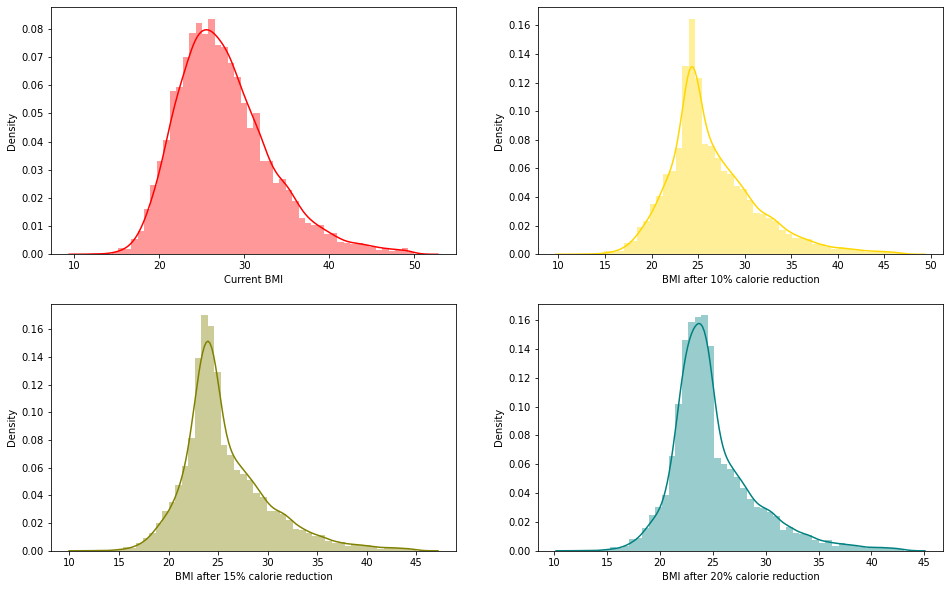

In [29]:
# Distributions of BMI currently and after calorie reduction

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

sns.distplot(
    full_hse["BMI_est"],
    color="red",
    kde=True,
    hist_kws={"weights": full_hse["sample_weight"]},
    ax=axs[0, 0],
)
sns.distplot(
    full_hse["final_BMI_10p"],
    color="gold",
    kde=True,
    hist_kws={"weights": full_hse["sample_weight"]},
    ax=axs[0, 1],
)
sns.distplot(
    full_hse["final_BMI_15p"],
    color="olive",
    kde=True,
    hist_kws={"weights": full_hse["sample_weight"]},
    ax=axs[1, 0],
)
sns.distplot(
    full_hse["final_BMI_20p"],
    color="teal",
    kde=True,
    hist_kws={"weights": full_hse["sample_weight"]},
    ax=axs[1, 1],
)

axs[0, 0].set_xlabel("Current BMI")
axs[0, 1].set_xlabel("BMI after 10% calorie reduction")
axs[1, 0].set_xlabel("BMI after 15% calorie reduction")
axs[1, 1].set_xlabel("BMI after 20% calorie reduction")


plt.show()

In [30]:
full_hse.reset_index(inplace = True)

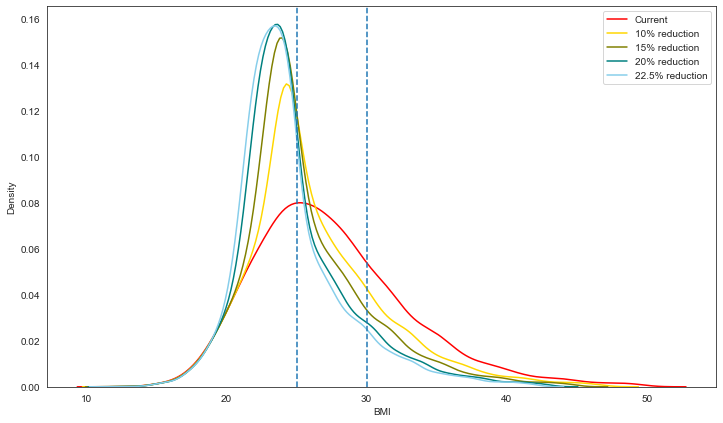

In [31]:
sns.set_style(style="white")

# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(12, 7))

ax = sns.kdeplot(full_hse["BMI_est"], color="red", label="Current", weights= full_hse["sample_weight"])
ax = sns.kdeplot(full_hse["final_BMI_10p"], color="gold", label="10% reduction", weights= full_hse["sample_weight"])
ax = sns.kdeplot(full_hse["final_BMI_15p"], color="olive", label="15% reduction", weights= full_hse["sample_weight"])
ax = sns.kdeplot(full_hse["final_BMI_20p"], color="teal", label="20% reduction", weights= full_hse["sample_weight"])
ax = sns.kdeplot(full_hse["final_BMI_22.5p"], color="skyblue", label="22.5% reduction", weights= full_hse["sample_weight"])

ax.axvline(25, ls="--")
ax.axvline(30, ls="--")

ax.set_xlabel("BMI")
# ax.set_ylabel("Density")
plt.legend()

In [32]:
# Recalculating total sample weight after excluding individuals with BMI exceeding 50
full_hse["sample_weight"].sum()

7909.047104216611

In [33]:
# Calculate sample share
full_hse["sample_share"] = full_hse["sample_weight"] / 7909.047104216611

In [34]:
# Share of overweight and obese
current_shares = full_hse.groupby("BMI_class")["sample_share"].sum()

In [35]:
sc_10p_shares = full_hse.groupby("final_BMI_class_10p")["sample_share"].sum()
sc_15p_shares = full_hse.groupby("final_BMI_class_15p")["sample_share"].sum()
sc_20p_shares = full_hse.groupby("final_BMI_class_20p")["sample_share"].sum()
sc_22p_shares = full_hse.groupby("final_BMI_class_22.5p")["sample_share"].sum()

In [36]:
# Prep data for plotting share of individuals across BMI classes under each modelled % reduction

In [37]:
combined_shares = pd.concat(
    [current_shares, sc_10p_shares, sc_15p_shares, sc_20p_shares, sc_22p_shares], axis=1
)

In [38]:
combined_shares.columns = ["current", "10p", "15p", "20p", "22.5p"]

In [39]:
combined_shares.loc["obese_overweight", :] = (
    combined_shares.loc["obese"] + combined_shares.loc["overweight"]
)

In [40]:
combined_shares2 = combined_shares.reset_index()

In [41]:
combined_shares2.round(3)

,index,current,10p,15p,20p,22.5p
0,normal,0.346,0.469,0.550,0.631,0.667
1,obese,0.279,0.191,0.145,0.109,0.092
2,overweight,0.357,0.322,0.287,0.242,0.223
3,underweight,0.018,0.018,0.018,0.018,0.018
4,obese_overweight,0.636,0.513,0.432,0.351,0.314


In [42]:
combined_shares2.columns = ["index", "Current", "10%", "15%", "20%", "22.5%"]

In [43]:
combined_shares3 = combined_shares2[combined_shares2["index"] != "obese_overweight"]

In [44]:
combined_shares4 = combined_shares2[combined_shares2["index"] == "obese_overweight"]

In [45]:
combined_shares4

,index,Current,10%,15%,20%,22.5%
4,obese_overweight,0.636032,0.512989,0.431599,0.35099,0.314331


In [46]:
combined_shares_flat = pd.melt(
    combined_shares3,
    id_vars=["index"],
    value_vars=["Current", "10%", "15%", "20%", "22.5%"],
)

In [47]:
combined_shares_flat2 = pd.melt(
    combined_shares4,
    id_vars=["index"],
    value_vars=["Current", "10%", "15%", "20%", "22.5%"],
)

In [48]:
combined_shares4["index"] = "Overweight or obese"

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/2054371699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_shares4["index"] = "Overweight or obese"


In [49]:
combined_shares_flat["percentage"] = combined_shares_flat["value"] * 100

In [50]:
combined_shares_flat2["percentage"] = combined_shares_flat2["value"] * 100

In [51]:
combined_shares_flat["index"] = combined_shares_flat["index"].apply(lambda x: x.title())

In [52]:
combined_shares_flat

,index,variable,value,percentage
0,Normal,Current,0.345671,34.567147
1,Obese,Current,0.278996,27.899647
2,Overweight,Current,0.357036,35.703595
3,Underweight,Current,0.018296,1.829611
4,Normal,10%,0.468715,46.871534
5,Obese,10%,0.191288,19.128800
6,Overweight,10%,0.321701,32.170055
7,Underweight,10%,0.018296,1.829611
8,Normal,15%,0.550105,55.010489
9,Obese,15%,0.144860,14.486014


Text(0, 0.5, 'Proportion of the population')

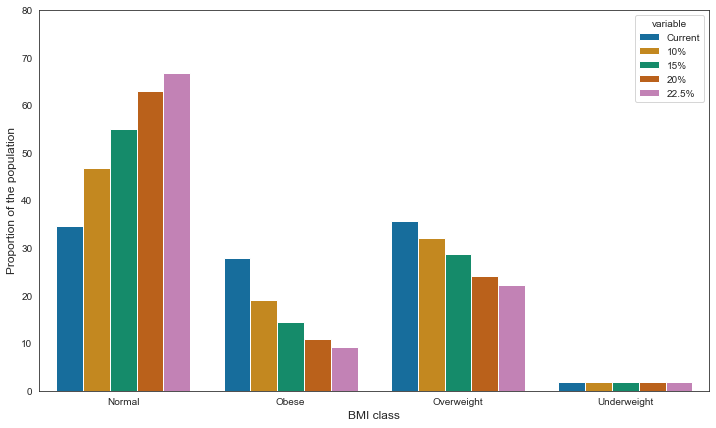

In [53]:
sns.set_style(style="white")

# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(12, 7))
ax = sns.barplot(
    x="index",
    y="percentage",
    hue="variable",
    data=combined_shares_flat,
    palette="colorblind",
)
ax.set_ylim(0, 80)

ax.set_xlabel("BMI class", fontsize=12)
ax.set_ylabel("Proportion of the population", fontsize=12)

Text(0, 0.5, 'Proportion of the population')

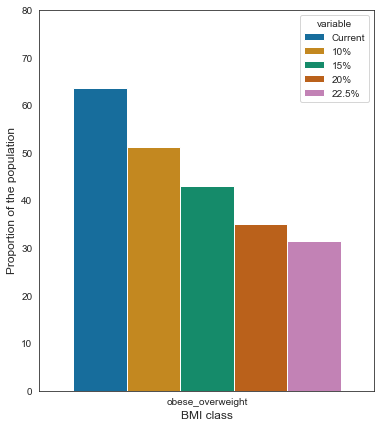

In [54]:
# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(6, 7))
ax = sns.barplot(
    x="index",
    y="percentage",
    hue="variable",
    data=combined_shares_flat2,
    palette="colorblind",
)
ax.set_ylim(0, 80)
ax.set_xlabel("BMI class", fontsize=12)
ax.set_ylabel("Proportion of the population", fontsize=12)

In [55]:
# Proportion of target weight reached
def assign_target_BMI(df):
    underweight = df[df["BMI_class"] == "underweight"]
    underweight["target_BMI"] = underweight["BMI_est"]
    normal_weight = df[df["BMI_class"] == "normal"]
#     normal_weight.loc[normal_weight["BMI_est"] > 22, "BMI_est"] = 22
    normal_weight["target_BMI"] = normal_weight["BMI_est"]
    overweight = df[df["BMI_class"] == "overweight"]
    overweight["target_BMI"] = 24.99
    obese = df[df["BMI_class"] == "obese"]
    obese["target_BMI"] = 29.99

    updated_df = pd.concat([underweight, normal_weight, overweight, obese])

    return updated_df

In [56]:
full_hse_upd = assign_target_BMI(full_hse)

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1556940288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underweight["target_BMI"] = underweight["BMI_est"]
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1556940288.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_weight["target_BMI"] = normal_weight["BMI_est"]
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1556940288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [57]:
full_hse_upd["target_weight"] = (
    full_hse_upd["target_BMI"] * full_hse_upd["Ht_est"] * full_hse_upd["Ht_est"] / 10000
)

In [58]:
full_hse_upd["target_weight_loss"] = full_hse_upd["Wt_est"] - full_hse_upd["target_weight"]
full_hse_upd.loc[full_hse_upd["BMI_class"] == "underweight", "target_weight_loss"] = 0

In [59]:
full_hse_upd[full_hse_upd["BMI_class"] == "overweight"][
    ["Wt_est", "finalWeight_10p", "target_weight"]
].head(20)

,Wt_est,finalWeight_10p,target_weight
2723,67.6,63.894274,58.499091
2725,68.0,64.587742,58.575585
2728,79.4,74.336713,69.861644
2729,69.5,65.384900,65.908026
2730,89.0,83.643486,88.287075
2731,79.5,75.023126,76.759453
2733,80.0,75.592310,76.531875
2740,98.1,92.332745,89.266779
2742,81.8,76.976712,79.178316
2751,94.4,89.067490,81.273766


In [60]:
full_hse_upd["weight_lost_10p"] = full_hse_upd["Wt_est"] - full_hse_upd["finalWeight_10p"]
full_hse_upd["weight_lost_15p"] = full_hse_upd["Wt_est"] - full_hse_upd["finalWeight_15p"]
full_hse_upd["weight_lost_20p"] = full_hse_upd["Wt_est"] - full_hse_upd["finalWeight_20p"]
full_hse_upd["weight_lost_22.5p"] = full_hse_upd["Wt_est"] - full_hse_upd["finalWeight_22.5p"]


full_hse_upd.loc[full_hse_upd["BMI_class"] == "underweight", "weight_lost_10p"] = 0
full_hse_upd.loc[full_hse_upd["BMI_class"] == "underweight", "weight_lost_15p"] = 0
full_hse_upd.loc[full_hse_upd["BMI_class"] == "underweight", "weight_lost_20p"] = 0
full_hse_upd.loc[full_hse_upd["BMI_class"] == "underweight", "weight_lost_22.5p"] = 0

In [61]:
full_hse_upd["prop_target_wt_10p"] = (
    full_hse_upd["weight_lost_10p"] / full_hse_upd["target_weight_loss"]
)
full_hse_upd["prop_target_wt_15p"] = (
    full_hse_upd["weight_lost_15p"] / full_hse_upd["target_weight_loss"]
)
full_hse_upd["prop_target_wt_20p"] = (
    full_hse_upd["weight_lost_20p"] / full_hse_upd["target_weight_loss"]
)
full_hse_upd["prop_target_wt_22.5p"] = (
    full_hse_upd["weight_lost_22.5p"] / full_hse_upd["target_weight_loss"]
)

In [62]:
full_hse_upd.loc[full_hse_upd["prop_target_wt_10p"] >= 1, "prop_target_wt_10p"] = 1
full_hse_upd.loc[full_hse_upd["prop_target_wt_15p"] >= 1, "prop_target_wt_15p"] = 1
full_hse_upd.loc[full_hse_upd["prop_target_wt_20p"] >= 1, "prop_target_wt_20p"] = 1
full_hse_upd.loc[full_hse_upd["prop_target_wt_22.5p"] >= 1, "prop_target_wt_22.5p"] = 1

In [63]:
full_hse_upd.loc[100:]

,index,Sex,Age_group,Age_est,Ethnicity,BMI_class,sample_weight,BMI_est,Wt_est,Ht_est,...,target_weight,target_weight_loss,weight_lost_10p,weight_lost_15p,weight_lost_20p,weight_lost_22.5p,prop_target_wt_10p,prop_target_wt_15p,prop_target_wt_20p,prop_target_wt_22.5p
100,363,male,85-89,87,White,normal,0.800926,24.463689,71.2,170.6,...,71.200000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
101,371,female,55-59,57,White,normal,0.848110,24.856381,68.0,165.4,...,68.000000,1.421085e-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
102,374,female,60-64,62,White,normal,0.453039,24.999036,64.8,161.0,...,64.800000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
103,383,male,55-59,57,White,normal,0.445865,24.508447,74.8,174.7,...,74.800000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
104,385,female,85-89,87,White,normal,0.482986,22.528851,52.6,152.8,...,52.600000,1.421085e-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7889,5205,female,30-34,32,White,obese,1.028935,31.583931,91.6,170.3,...,86.977268,4.622732e+00,6.905297,10.662096,14.341563,16.151591,1.000000,1.000000,1.000000,1.0
7890,5206,male,35-39,37,White,obese,1.207406,30.945712,98.6,178.5,...,95.554888,3.045112e+00,6.047123,9.973562,13.822695,15.717619,1.000000,1.000000,1.000000,1.0
7892,5208,male,60-64,62,White,obese,1.026475,34.686603,98.6,168.6,...,85.249454,1.335055e+01,5.471341,8.951844,12.377540,14.069451,0.409822,0.670523,0.927119,1.0
7894,5210,female,30-34,32,White,obese,1.143296,30.865052,89.2,170.0,...,86.671100,2.528900e+00,6.746127,10.403710,13.984898,15.746158,1.000000,1.000000,1.000000,1.0


In [64]:
lost_weight = full_hse_upd.groupby("BMI_class").agg(
    {
        "target_weight_loss": lambda x: np.median(x),
        "weight_lost_10p": lambda x: np.median(x),
        "weight_lost_15p": lambda x: np.median(x),
        "weight_lost_20p": lambda x: np.median(x),
        "weight_lost_22.5p": lambda x: np.median(x),
        "prop_target_wt_10p": lambda x: np.median(x),
        "prop_target_wt_15p": lambda x: np.median(x),
        "prop_target_wt_20p": lambda x: np.median(x),
        "prop_target_wt_22.5p": lambda x: np.median(x),
        "sample_share": sum,
    }
)

In [65]:
lost_weight

,target_weight_loss,weight_lost_10p,weight_lost_15p,weight_lost_20p,weight_lost_22.5p,prop_target_wt_10p,prop_target_wt_15p,prop_target_wt_20p,prop_target_wt_22.5p,sample_share
BMI_class,,,,,,,,,,
normal,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.345671
obese,9.305299,5.619803,9.207676,12.704065,14.430358,0.589896,0.959033,1.0,1.0,0.278996
overweight,6.490788,4.521880,7.412717,10.259314,11.652264,0.698785,1.000000,1.0,1.0,0.357036
underweight,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.018296


#### Save outputs

In [66]:
lost_weight.to_csv(os.path.join(proj_path, "lost_weight.csv"))

In [67]:
combined_shares.to_csv(os.path.join(proj_path, "bmi_class_proportions.csv"))

In [68]:
combined_scenarios = full_hse.merge(
    full_hse_upd[
        [
            "target_BMI",
            "target_weight",
            "target_weight_loss",
            "weight_lost_10p",
            "weight_lost_15p",
            "weight_lost_20p",
            "weight_lost_22.5p",
        ]
    ],
    right_index=True,
    left_index=True,
)

In [70]:
full_hse.to_csv(os.path.join(proj_path, "scenario2_agg_results.csv"), index = False)

In [71]:
combined_scenarios.to_csv(os.path.join(proj_path, "combined_scenarios_upd.csv"), index = False)

In [72]:
combined_scenarios.head()

,index,Sex,Age_group,Age_est,Ethnicity,BMI_class,sample_weight,BMI_est,Wt_est,Ht_est,...,final_BMI_class_22.5p,X,sample_share,target_BMI,target_weight,target_weight_loss,weight_lost_10p,weight_lost_15p,weight_lost_20p,weight_lost_22.5p
0,1,male,45-49,47,Asian,normal,0.949745,18.503251,52.0,167.64,...,normal,NaN,0.000120,18.503251,52.0,0.000000e+00,0.0,0.0,0.0,0.0
1,2,male,35-39,37,Asian,normal,1.129456,22.867883,65.7,169.50,...,normal,NaN,0.000143,22.867883,65.7,1.421085e-14,0.0,0.0,0.0,0.0
2,16,female,40-44,42,Asian,normal,1.005056,22.838625,59.2,161.00,...,normal,NaN,0.000127,22.838625,59.2,-7.105427e-15,0.0,0.0,0.0,0.0
3,32,female,45-49,47,White,normal,0.770664,20.665034,53.3,160.60,...,normal,NaN,0.000097,20.665034,53.3,0.000000e+00,0.0,0.0,0.0,0.0
4,41,female,65-69,67,White,normal,0.769815,24.354887,60.4,157.48,...,normal,NaN,0.000097,24.354887,60.4,7.105427e-15,0.0,0.0,0.0,0.0


## Subgroup analysis

Steps
1. Create dict with group sizes for Sex, Age, Ethnicity and IMD quantile
2. For each % reduction show % of original obese that remain obese:
    - Sex
    - Age group
    - Ethnicity
    - IMD quantile

In [73]:
# Step 1
group_sizes = collections.defaultdict(dict)
vars = ['Sex', 'Age_group', 'Ethnicity', 'IMD_q']
for var in vars:
    for name, group in full_hse.groupby(var):
        group_sizes[var][name] = len(group)

In [74]:
group_sizes['Ethnicity']

{'Asian': 696, 'Black': 224, 'Mixed': 127, 'Other': 69, 'White': 6782}

In [75]:
# Step 2

In [76]:
ob_ov2 = full_hse[(full_hse['BMI_class'] == 'obese') | (full_hse['BMI_class'] == 'overweight')]

In [77]:
# Sex
group_dfs = []
scenarios = ['final_BMI_class_10p', 'final_BMI_class_15p', 'final_BMI_class_20p', 'final_BMI_class_22.5p']
base = ['Sex', 'BMI_class']

for s in scenarios:
    groupby_args = base + [s]
    new_df = ob_ov2.groupby(groupby_args).size().reset_index()
    group_dfs.append(new_df)
    new_df.columns = groupby_args + ['Count']
df_list = pd.concat(group_dfs, ignore_index=True)

In [79]:
prop_remain_sex = []
for s in scenarios:
    remain_obese_sex = df_list[(df_list['BMI_class'] == 'obese') & (df_list[s] == 'obese')]
    remain_obese_sex['group_size'] = remain_obese_sex['Sex'].apply(lambda x: group_sizes['Sex'][x])
    remain_obese_sex['prop_remain'] = remain_obese_sex['Count']/remain_obese_sex['group_size']
    prop_remain_sex.append(remain_obese_sex)

all_dfs_sex = pd.concat(prop_remain_sex)

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/493898899.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_sex['group_size'] = remain_obese_sex['Sex'].apply(lambda x: group_sizes['Sex'][x])
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/493898899.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_sex['prop_remain'] = remain_obese_sex['Count']/remain_obese_sex['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/493898

In [80]:
all_dfs_sex

,Sex,BMI_class,final_BMI_class_10p,Count,final_BMI_class_15p,final_BMI_class_20p,final_BMI_class_22.5p,group_size,prop_remain
0,female,obese,obese,923,NaN,NaN,NaN,4320,0.213657
4,male,obese,obese,673,NaN,NaN,NaN,3578,0.188094
8,female,obese,NaN,713,obese,NaN,NaN,4320,0.165046
12,male,obese,NaN,496,obese,NaN,NaN,3578,0.138625
17,female,obese,NaN,559,NaN,obese,NaN,4320,0.129398
21,male,obese,NaN,360,NaN,obese,NaN,3578,0.100615
26,female,obese,NaN,482,NaN,NaN,obese,4320,0.111574
31,male,obese,NaN,295,NaN,NaN,obese,3578,0.082448


In [81]:
# Age
group_dfs = []
scenarios = ['final_BMI_class_10p', 'final_BMI_class_15p', 'final_BMI_class_20p', 'final_BMI_class_22.5p']
base = ['Age_group', 'BMI_class']

for s in scenarios:
    groupby_args = base + [s]
    new_df = ob_ov2.groupby(groupby_args).size().reset_index()
    group_dfs.append(new_df)
    new_df.columns = groupby_args + ['Count']
df_list = pd.concat(group_dfs, ignore_index=True)

In [82]:
prop_remain_age = []
for s in scenarios:
    remain_obese_age = df_list[(df_list['BMI_class'] == 'obese') & (df_list[s] == 'obese')]
    remain_obese_age['group_size'] = remain_obese_age['Age_group'].apply(lambda x: group_sizes['Age_group'][x])
    remain_obese_age['prop_remain'] = remain_obese_age['Count']/remain_obese_age['group_size']
    prop_remain_age.append(remain_obese_age)

all_dfs_age = pd.concat(prop_remain_age)

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/3918481978.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_age['group_size'] = remain_obese_age['Age_group'].apply(lambda x: group_sizes['Age_group'][x])
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/3918481978.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_age['prop_remain'] = remain_obese_age['Count']/remain_obese_age['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykerne

In [83]:
all_dfs_age.head(10)

,Age_group,BMI_class,final_BMI_class_10p,Count,final_BMI_class_15p,final_BMI_class_20p,final_BMI_class_22.5p,group_size,prop_remain
0,16-19,obese,obese,28,NaN,NaN,NaN,334,0.083832
4,20-24,obese,obese,30,NaN,NaN,NaN,360,0.083333
8,25-29,obese,obese,65,NaN,NaN,NaN,457,0.142232
12,30-34,obese,obese,93,NaN,NaN,NaN,576,0.161458
16,35-39,obese,obese,128,NaN,NaN,NaN,702,0.182336
20,40-44,obese,obese,131,NaN,NaN,NaN,641,0.204368
24,45-49,obese,obese,153,NaN,NaN,NaN,660,0.231818
28,50-54,obese,obese,176,NaN,NaN,NaN,713,0.246844
32,55-59,obese,obese,161,NaN,NaN,NaN,661,0.243570
36,60-64,obese,obese,153,NaN,NaN,NaN,635,0.240945


In [84]:
full_hse[(full_hse['Age_group'] == '35-39') & (full_hse['BMI_class'] == 'obese') & (full_hse['final_BMI_class_10p'] == 'obese')]

,index,Sex,Age_group,Age_est,Ethnicity,BMI_class,sample_weight,BMI_est,Wt_est,Ht_est,...,final_BMI_15p,final_BMI_class_15p,finalWeight_20p,final_BMI_20p,final_BMI_class_20p,finalWeight_22.5p,final_BMI_22.5p,final_BMI_class_22.5p,X,sample_share
2863,144,female,35-39,37,White,obese,0.526713,43.578796,112.4,160.6,...,39.072729,obese,96.267831,37.324165,obese,94.044455,36.462137,obese,281.0,0.000067
2872,153,male,35-39,37,White,obese,0.523605,45.847196,150.2,181.0,...,41.276639,obese,129.437993,39.509781,obese,126.579016,38.637104,obese,303.0,0.000066
2909,191,male,35-39,37,White,obese,0.523605,34.400272,114.7,182.6,...,30.949790,obese,98.758054,29.619040,overweight,96.570632,28.962999,overweight,378.0,0.000066
2965,247,male,35-39,37,White,obese,0.939123,38.232205,138.6,190.4,...,34.418062,obese,119.433944,32.945332,obese,116.798183,32.218269,obese,471.0,0.000119
2973,255,female,35-39,37,White,obese,1.262227,35.279760,99.1,167.6,...,31.569985,obese,84.669540,30.142493,obese,82.695232,29.439636,overweight,485.0,0.000160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,5038,female,35-39,37,White,obese,0.590469,45.176605,126.9,167.6,...,40.579399,obese,108.972337,38.794328,obese,106.497109,37.913143,obese,9958.0,0.000075
7734,5049,male,35-39,37,White,obese,1.159456,50.000000,162.0,180.0,...,45.010420,obese,139.572034,43.077788,obese,136.478007,42.122842,obese,9977.0,0.000147
7782,5097,female,35-39,37,White,obese,0.792541,41.180938,114.3,166.6,...,36.928869,obese,97.917099,35.278373,obese,95.658224,34.464527,obese,10064.0,0.000100
7870,5186,female,35-39,37,White,obese,0.778682,32.951081,90.8,166.0,...,29.438967,overweight,77.458920,28.109639,overweight,75.656671,27.455607,overweight,10248.0,0.000098


In [85]:
# Ethnicity
group_dfs = []
scenarios = ['final_BMI_class_10p', 'final_BMI_class_15p', 'final_BMI_class_20p', 'final_BMI_class_22.5p']
base = ['Ethnicity', 'BMI_class']

for s in scenarios:
    groupby_args = base + [s]
    new_df = ob_ov2.groupby(groupby_args).size().reset_index()
    group_dfs.append(new_df)
    new_df.columns = groupby_args + ['Count']
df_list = pd.concat(group_dfs, ignore_index=True)

In [86]:
prop_remain_ethn = []
for s in scenarios:
    remain_obese_ethn = df_list[(df_list['BMI_class'] == 'obese') & (df_list[s] == 'obese')]
    remain_obese_ethn['group_size'] = remain_obese_ethn['Ethnicity'].apply(lambda x: group_sizes['Ethnicity'][x])
    remain_obese_ethn['prop_remain'] = remain_obese_ethn['Count']/remain_obese_ethn['group_size']
    prop_remain_ethn.append(remain_obese_ethn)

all_dfs_ethn = pd.concat(prop_remain_ethn)

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/986277605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_ethn['group_size'] = remain_obese_ethn['Ethnicity'].apply(lambda x: group_sizes['Ethnicity'][x])
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/986277605.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_ethn['prop_remain'] = remain_obese_ethn['Count']/remain_obese_ethn['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipyke

In [87]:
all_dfs_ethn

,Ethnicity,BMI_class,final_BMI_class_10p,Count,final_BMI_class_15p,final_BMI_class_20p,final_BMI_class_22.5p,group_size,prop_remain
0,Asian,obese,obese,86,NaN,NaN,NaN,696,0.123563
4,Black,obese,obese,50,NaN,NaN,NaN,224,0.223214
8,Mixed,obese,obese,15,NaN,NaN,NaN,127,0.118110
12,Other,obese,obese,16,NaN,NaN,NaN,69,0.231884
16,White,obese,obese,1429,NaN,NaN,NaN,6782,0.210705
20,Asian,obese,NaN,52,obese,NaN,NaN,696,0.074713
24,Black,obese,NaN,36,obese,NaN,NaN,224,0.160714
28,Mixed,obese,NaN,10,obese,NaN,NaN,127,0.078740
32,Other,obese,NaN,14,obese,NaN,NaN,69,0.202899
36,White,obese,NaN,1097,obese,NaN,NaN,6782,0.161752


In [88]:
# IMD
group_dfs = []
scenarios = ['final_BMI_class_10p', 'final_BMI_class_15p', 'final_BMI_class_20p', 'final_BMI_class_22.5p']
base = ['IMD_q', 'BMI_class']

for s in scenarios:
    groupby_args = base + [s]
    new_df = ob_ov2.groupby(groupby_args).size().reset_index()
    group_dfs.append(new_df)
    new_df.columns = groupby_args + ['Count']
df_list = pd.concat(group_dfs, ignore_index=True)

In [89]:
prop_remain_imd = []
for s in scenarios:
    remain_obese_imd = df_list[(df_list['BMI_class'] == 'obese') & (df_list[s] == 'obese')]
    remain_obese_imd['group_size'] = remain_obese_imd['IMD_q'].apply(lambda x: group_sizes['IMD_q'][x])
    remain_obese_imd['prop_remain'] = remain_obese_imd['Count']/remain_obese_imd['group_size']
    prop_remain_imd.append(remain_obese_imd)

all_dfs_imd = pd.concat(prop_remain_imd)

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/4166183118.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_imd['group_size'] = remain_obese_imd['IMD_q'].apply(lambda x: group_sizes['IMD_q'][x])
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/4166183118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_imd['prop_remain'] = remain_obese_imd['Count']/remain_obese_imd['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/

In [90]:
all_dfs_imd.tail(10)

,IMD_q,BMI_class,final_BMI_class_10p,Count,final_BMI_class_15p,final_BMI_class_20p,final_BMI_class_22.5p,group_size,prop_remain
41,1,obese,NaN,127,NaN,obese,NaN,1625,0.078154
46,2,obese,NaN,149,NaN,obese,NaN,1536,0.097005
50,3,obese,NaN,186,NaN,obese,NaN,1547,0.120233
54,4,obese,NaN,189,NaN,obese,NaN,1562,0.120999
58,5,obese,NaN,268,NaN,obese,NaN,1628,0.164619
63,1,obese,NaN,106,NaN,NaN,obese,1625,0.065231
68,2,obese,NaN,120,NaN,NaN,obese,1536,0.078125
73,3,obese,NaN,152,NaN,NaN,obese,1547,0.098255
78,4,obese,NaN,154,NaN,NaN,obese,1562,0.098592
83,5,obese,NaN,245,NaN,NaN,obese,1628,0.150491


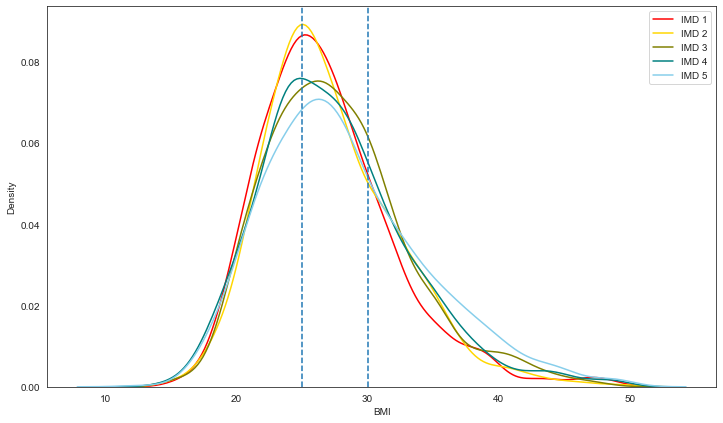

In [91]:
# Plot BMI by IMD

sns.set_style(style="white")

# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(12, 7))

imd_1 = full_hse[full_hse["IMD_q"] == 1]
imd_2 = full_hse[full_hse["IMD_q"] == 2]
imd_3 = full_hse[full_hse["IMD_q"] == 3]
imd_4 = full_hse[full_hse["IMD_q"] == 4]
imd_5 = full_hse[full_hse["IMD_q"] == 5]

ax = sns.kdeplot(imd_1['BMI_est'], color="red", label="IMD 1", weights= imd_1["sample_weight"])
ax = sns.kdeplot(imd_2['BMI_est'], color="gold", label="IMD 2", weights= imd_2["sample_weight"])
ax = sns.kdeplot(imd_3['BMI_est'], color="olive", label="IMD 3", weights= imd_3["sample_weight"])
ax = sns.kdeplot(imd_4['BMI_est'], color="teal", label="IMD 4", weights= imd_4["sample_weight"])
ax = sns.kdeplot(imd_5['BMI_est'], color="skyblue", label="IMD 5", weights= imd_5["sample_weight"])

ax.axvline(25, ls="--")
ax.axvline(30, ls="--")

ax.set_xlabel("BMI")
# ax.set_ylabel("Density")
plt.legend()

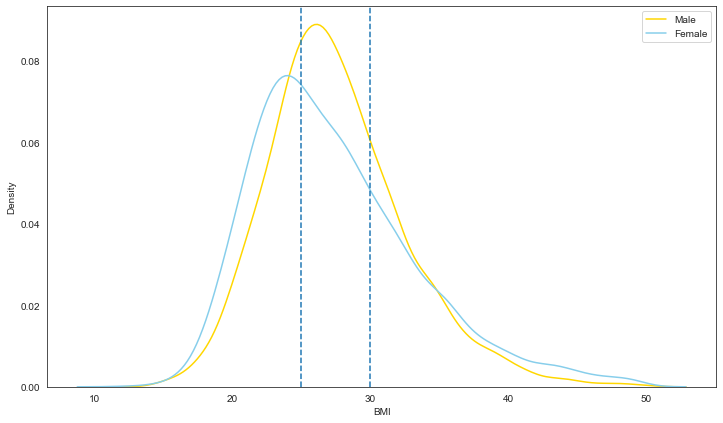

In [92]:
# Plot BMI by Sex

sns.set_style(style="white")

# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(12, 7))

male = full_hse[full_hse["Sex"] == 'male']
female = full_hse[full_hse["Sex"] == 'female']


ax = sns.kdeplot(male['BMI_est'], color="gold", label="Male", weights= male["sample_weight"])
ax = sns.kdeplot(female['BMI_est'], color="skyblue", label="Female", weights= female["sample_weight"])

ax.axvline(25, ls="--")
ax.axvline(30, ls="--")

ax.set_xlabel("BMI")
# ax.set_ylabel("Density")
plt.legend()

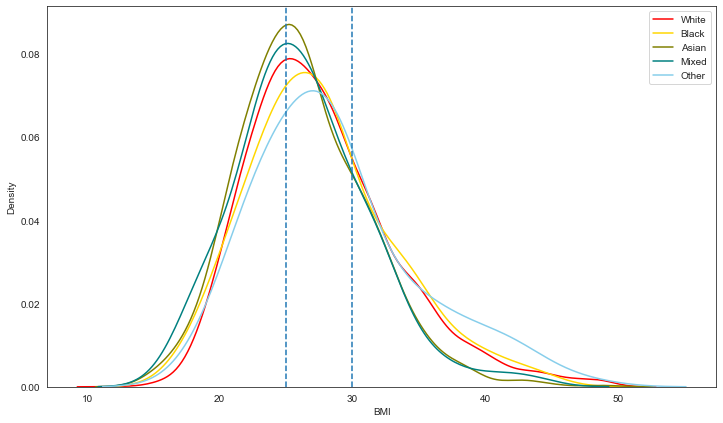

In [93]:
# Plot BMI by Ethnicity

sns.set_style(style="white")

# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(12, 7))

white = full_hse[full_hse["Ethnicity"] == 'White']
black = full_hse[full_hse["Ethnicity"] == 'Black']
asian = full_hse[full_hse["Ethnicity"] == 'Asian']
mixed = full_hse[full_hse["Ethnicity"] == 'Mixed']
other = full_hse[full_hse["Ethnicity"] == 'Other']

ax = sns.kdeplot(white['BMI_est'], color="red", label="White", weights= white["sample_weight"])
ax = sns.kdeplot(black['BMI_est'], color="gold", label="Black", weights= black["sample_weight"])
ax = sns.kdeplot(asian['BMI_est'], color="olive", label="Asian", weights= asian["sample_weight"])
ax = sns.kdeplot(mixed['BMI_est'], color="teal", label="Mixed", weights= mixed["sample_weight"])
ax = sns.kdeplot(other['BMI_est'], color="skyblue", label="Other", weights= other["sample_weight"])

ax.axvline(25, ls="--")
ax.axvline(30, ls="--")

ax.set_xlabel("BMI")
# ax.set_ylabel("Density")
plt.legend()

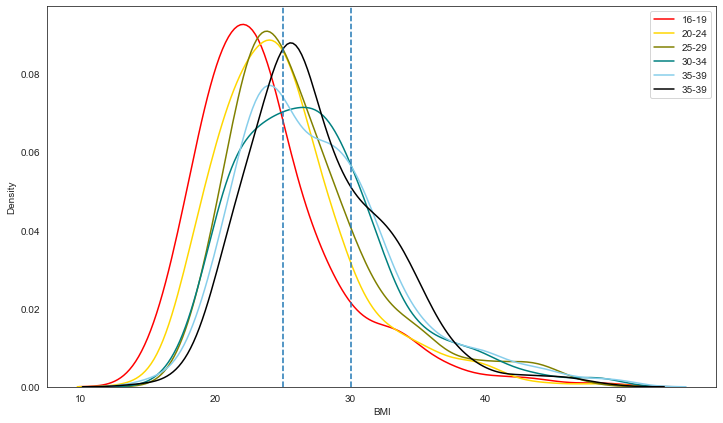

In [94]:
# Plot BMI by Age 1

sns.set_style(style="white")

# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(12, 7))

age1 = full_hse[full_hse["Age_group"] == '16-19']
age2 = full_hse[full_hse["Age_group"] == '20-24']
age3 = full_hse[full_hse["Age_group"] == '25-29']
age4 = full_hse[full_hse["Age_group"] == '30-34']
age5 = full_hse[full_hse["Age_group"] == '35-39']
age6 = full_hse[full_hse["Age_group"] == '40-44']

ax = sns.kdeplot(age1['BMI_est'], color="red", label="16-19", weights= age1["sample_weight"])
ax = sns.kdeplot(age2['BMI_est'], color="gold", label="20-24", weights= age2["sample_weight"])
ax = sns.kdeplot(age3['BMI_est'], color="olive", label="25-29", weights= age3["sample_weight"])
ax = sns.kdeplot(age4['BMI_est'], color="teal", label="30-34", weights= age4["sample_weight"])
ax = sns.kdeplot(age5['BMI_est'], color="skyblue", label="35-39", weights= age5["sample_weight"])
ax = sns.kdeplot(age6['BMI_est'], color="black", label="35-39", weights= age6["sample_weight"])


ax.axvline(25, ls="--")
ax.axvline(30, ls="--")

ax.set_xlabel("BMI")
# ax.set_ylabel("Density")
plt.legend()

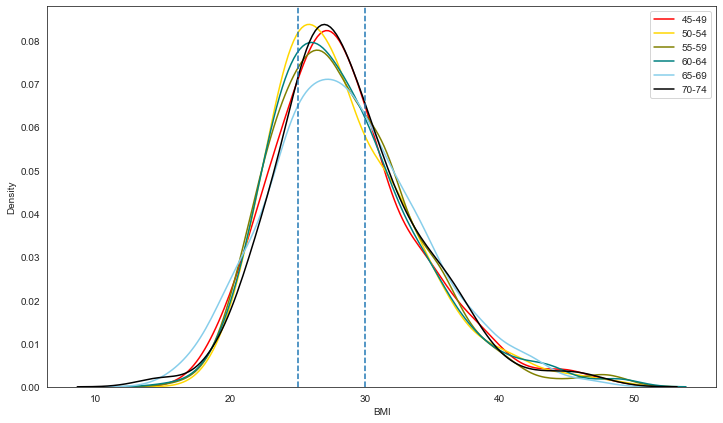

In [96]:
# Plot BMI by Age (remaining groups 2)

sns.set_style(style="white")

# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(12, 7))

age1 = full_hse[full_hse["Age_group"] == '45-49']
age2 = full_hse[full_hse["Age_group"] == '50-54']
age3 = full_hse[full_hse["Age_group"] == '55-59']
age4 = full_hse[full_hse["Age_group"] == '60-64']
age5 = full_hse[full_hse["Age_group"] == '65-69']
age6 = full_hse[full_hse["Age_group"] == '70-74']

ax = sns.kdeplot(age1['BMI_est'], color="red", label="45-49", weights= age1["sample_weight"])
ax = sns.kdeplot(age2['BMI_est'], color="gold", label="50-54", weights= age2["sample_weight"])
ax = sns.kdeplot(age3['BMI_est'], color="olive", label="55-59", weights= age3["sample_weight"])
ax = sns.kdeplot(age4['BMI_est'], color="teal", label="60-64", weights= age4["sample_weight"])
ax = sns.kdeplot(age5['BMI_est'], color="skyblue", label="65-69", weights= age5["sample_weight"])
ax = sns.kdeplot(age6['BMI_est'], color="black", label="70-74", weights= age6["sample_weight"])


ax.axvline(25, ls="--")
ax.axvline(30, ls="--")

ax.set_xlabel("BMI")
# ax.set_ylabel("Density")
plt.legend()

In [97]:
all_dfs_age.tail(20)

,Age_group,BMI_class,final_BMI_class_10p,Count,final_BMI_class_15p,final_BMI_class_20p,final_BMI_class_22.5p,group_size,prop_remain
178,75-79,obese,NaN,50,NaN,obese,NaN,447,0.111857
182,80-84,obese,NaN,25,NaN,obese,NaN,284,0.088028
186,85-89,obese,NaN,12,NaN,obese,NaN,161,0.074534
190,90+,obese,NaN,2,NaN,obese,NaN,61,0.032787
195,16-19,obese,NaN,13,NaN,NaN,obese,334,0.038922
199,20-24,obese,NaN,13,NaN,NaN,obese,360,0.036111
203,25-29,obese,NaN,35,NaN,NaN,obese,457,0.076586
208,30-34,obese,NaN,47,NaN,NaN,obese,576,0.081597
212,35-39,obese,NaN,66,NaN,NaN,obese,702,0.094017
216,40-44,obese,NaN,50,NaN,NaN,obese,641,0.078003


## Subgroup analysis for scenarios 3 and 4

In [104]:
sc3 = pd.read_csv(os.path.join(proj_path, "hse_modelling_scenario_3.csv"))

In [105]:
len(sc3)

2353

In [106]:
sc4 = pd.read_csv(os.path.join(proj_path, "hse_modelling_scenario_4.csv"))

In [107]:
sc3.head()

,id,time,f,FFM,weight,calRed,baseIntake,newIntake,RMR,PA,...,BMI_est,Wt_est,Ht_est,IMD_q,Sex_letter,trg,rnd,target,final_BMI,final_BMI_class
0,3,1095,31.744954,47.780824,79.525778,0.050000,2494.208032,2369.497630,1515.748991,0.000000,...,30.120438,83.2,166.20,4,F,80.105076,0,83.200000,28.790280,overweight
1,7,1095,25.708167,40.066521,65.774688,0.168640,2402.224000,1997.112431,1383.324322,0.000000,...,32.214853,76.5,154.10,5,F,68.865749,1,68.865749,27.698326,overweight
2,10,1095,31.118736,45.559306,76.678042,0.121544,2492.816788,2189.829298,1387.655861,43.357454,...,30.671948,83.1,164.60,5,F,78.570164,1,78.570164,28.301624,overweight
3,25,1095,35.608949,47.692384,83.301333,0.050000,2519.345500,2393.378225,1397.102153,95.011660,...,30.245699,85.0,167.64,4,F,81.499192,0,85.000000,29.641259,overweight
4,27,1095,28.155342,37.309064,65.464407,0.325111,2494.208032,1683.312352,1202.013777,97.001338,...,37.983930,83.2,148.00,5,F,63.521600,1,63.521600,29.886964,overweight


In [108]:
len(full_hse[full_hse['BMI_est']>=40])

251

In [109]:
# Age
groupby_args = ['Age_group', 'BMI_class', 'final_BMI_class']
new_df = sc3.groupby(groupby_args).size().reset_index()
new_df.columns = groupby_args + ['Count']

remain_obese_age = new_df[(new_df['BMI_class'] == 'obese') & (new_df['final_BMI_class'] == 'obese')]
remain_obese_age['group_size'] = 2353
# remain_obese_age['group_size'] = remain_obese_age['Age_group'].apply(lambda x: group_sizes['Age_group'][x])

remain_obese_age['prop_remain'] = remain_obese_age['Count']/remain_obese_age['group_size']

remain_obese_age['Scenario'] = '3'

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/2877749217.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_age['group_size'] = 2353
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/2877749217.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_age['prop_remain'] = remain_obese_age['Count']/remain_obese_age['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/2877749217.py:12: SettingWithCopyWarning: 
A value is trying 

In [110]:
groupby_args = ['Age_group', 'BMI_class', 'final_BMI_class']
new_df = sc4.groupby(groupby_args).size().reset_index()
new_df.columns = groupby_args + ['Count']

remain_obese_age2 = new_df[(new_df['BMI_class'] == 'obese') & (new_df['final_BMI_class'] == 'obese')]
remain_obese_age2['group_size'] = 2353
# remain_obese_age2['group_size'] = remain_obese_age2['Age_group'].apply(lambda x: group_sizes['Age_group'][x])
remain_obese_age2['prop_remain'] = remain_obese_age2['Count']/remain_obese_age2['group_size']

remain_obese_age2['Scenario'] = '4'

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1678229358.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_age2['group_size'] = 2353
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1678229358.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_age2['prop_remain'] = remain_obese_age2['Count']/remain_obese_age2['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1678229358.py:10: SettingWithCopyWarning: 
A value is tryi

In [111]:
remain_obese_age_compare = pd.concat([remain_obese_age, remain_obese_age2])

In [112]:
remain_obese_age_compare

,Age_group,BMI_class,final_BMI_class,Count,group_size,prop_remain,Scenario
0,16-19,obese,obese,21,2353,0.008925,3
3,20-24,obese,obese,23,2353,0.009775,3
6,25-29,obese,obese,42,2353,0.017850,3
8,30-34,obese,obese,63,2353,0.026774,3
10,35-39,obese,obese,89,2353,0.037824,3
12,40-44,obese,obese,79,2353,0.033574,3
14,45-49,obese,obese,120,2353,0.050999,3
16,50-54,obese,obese,119,2353,0.050574,3
18,55-59,obese,obese,120,2353,0.050999,3
20,60-64,obese,obese,107,2353,0.045474,3


Text(0, 0.5, 'Proportion of all obese individuals')

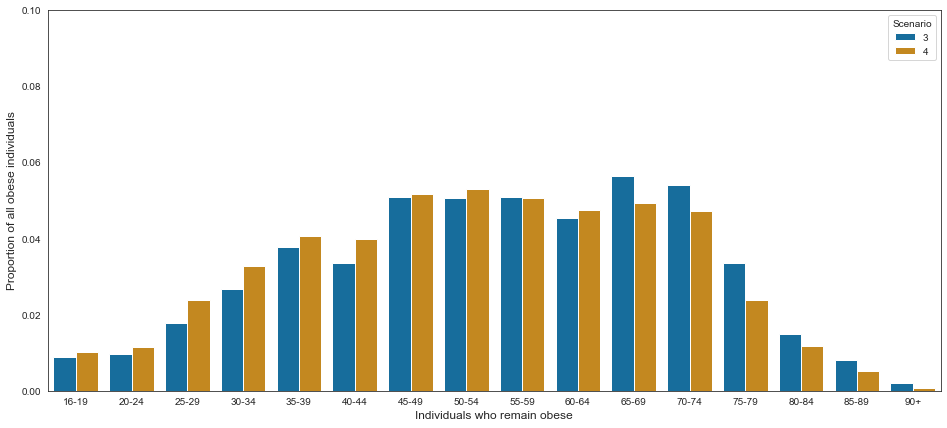

In [113]:
# sns.set_style(style="white")

# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(16, 7))
ax = sns.barplot(
    x="Age_group",
    y="prop_remain",
    hue="Scenario",
    data=remain_obese_age_compare,
    palette="colorblind",
)
ax.set_ylim(0, 0.1)

ax.set_xlabel("Individuals who remain obese", fontsize=12)
ax.set_ylabel("Proportion of all obese individuals", fontsize=12)

In [114]:
remain_obese_age['group_size'].sum()

37648

In [115]:
remain_obese_age_compare2 = remain_obese_age.merge(remain_obese_age2, 
                                                   left_on = ['Age_group', 'BMI_class', 'final_BMI_class'],
                                                  right_on = ['Age_group', 'BMI_class', 'final_BMI_class'],
                                                  suffixes = ['_sc3', '_sc4'])

In [116]:
remain_obese_age_compare2['diff'] = remain_obese_age_compare2['prop_remain_sc3'] - remain_obese_age_compare2['prop_remain_sc4']

In [117]:
remain_obese_age_compare2

,Age_group,BMI_class,final_BMI_class,Count_sc3,group_size_sc3,prop_remain_sc3,Scenario_sc3,Count_sc4,group_size_sc4,prop_remain_sc4,Scenario_sc4,diff
0,16-19,obese,obese,21,2353,0.008925,3,24,2353,0.010200,4,-0.001275
1,20-24,obese,obese,23,2353,0.009775,3,27,2353,0.011475,4,-0.001700
2,25-29,obese,obese,42,2353,0.017850,3,56,2353,0.023799,4,-0.005950
3,30-34,obese,obese,63,2353,0.026774,3,77,2353,0.032724,4,-0.005950
4,35-39,obese,obese,89,2353,0.037824,3,96,2353,0.040799,4,-0.002975
5,40-44,obese,obese,79,2353,0.033574,3,94,2353,0.039949,4,-0.006375
6,45-49,obese,obese,120,2353,0.050999,3,122,2353,0.051849,4,-0.000850
7,50-54,obese,obese,119,2353,0.050574,3,125,2353,0.053124,4,-0.002550
8,55-59,obese,obese,120,2353,0.050999,3,119,2353,0.050574,4,0.000425
9,60-64,obese,obese,107,2353,0.045474,3,112,2353,0.047599,4,-0.002125


In [118]:
# IMD
groupby_args = ['IMD_q', 'BMI_class', 'final_BMI_class']
new_df = sc3.groupby(groupby_args).size().reset_index()
new_df.columns = groupby_args + ['Count']

remain_obese_imd = new_df[(new_df['BMI_class'] == 'obese') & (new_df['final_BMI_class'] == 'obese')]
remain_obese_imd['group_size'] = 2353
# remain_obese_imd['group_size'] = remain_obese_imd['IMD_q'].apply(lambda x: group_sizes['IMD_q'][x])

remain_obese_imd['prop_remain'] = remain_obese_imd['Count']/remain_obese_imd['group_size']

remain_obese_imd['Scenario'] = '3'

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/469748158.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_imd['group_size'] = 2353
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/469748158.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_imd['prop_remain'] = remain_obese_imd['Count']/remain_obese_imd['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/469748158.py:12: SettingWithCopyWarning: 
A value is trying to 

In [119]:
groupby_args = ['IMD_q', 'BMI_class', 'final_BMI_class']
new_df = sc4.groupby(groupby_args).size().reset_index()
new_df.columns = groupby_args + ['Count']

remain_obese_imd2 = new_df[(new_df['BMI_class'] == 'obese') & (new_df['final_BMI_class'] == 'obese')]
remain_obese_imd2['group_size'] = 2353
# remain_obese_imd2['group_size'] = remain_obese_imd2['IMD_q'].apply(lambda x: group_sizes['IMD_q'][x])
remain_obese_imd2['prop_remain'] = remain_obese_imd2['Count']/remain_obese_imd2['group_size']

remain_obese_imd2['Scenario'] = '4'

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/992132279.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_imd2['group_size'] = 2353
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/992132279.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_imd2['prop_remain'] = remain_obese_imd2['Count']/remain_obese_imd2['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/992132279.py:10: SettingWithCopyWarning: 
A value is trying 

In [120]:
remain_obese_imd_compare = pd.concat([remain_obese_imd, remain_obese_imd2])

In [121]:
remain_obese_imd_compare

,IMD_q,BMI_class,final_BMI_class,Count,group_size,prop_remain,Scenario
0,1,obese,obese,179,2353,0.076073,3
2,2,obese,obese,204,2353,0.086698,3
4,3,obese,obese,253,2353,0.107522,3
6,4,obese,obese,243,2353,0.103272,3
9,5,obese,obese,302,2353,0.128347,3
0,1,obese,obese,158,2353,0.067148,4
2,2,obese,obese,198,2353,0.084148,4
4,3,obese,obese,228,2353,0.096898,4
6,4,obese,obese,246,2353,0.104547,4
8,5,obese,obese,347,2353,0.147471,4


Text(0, 0.5, 'Proportion of obese individuals')

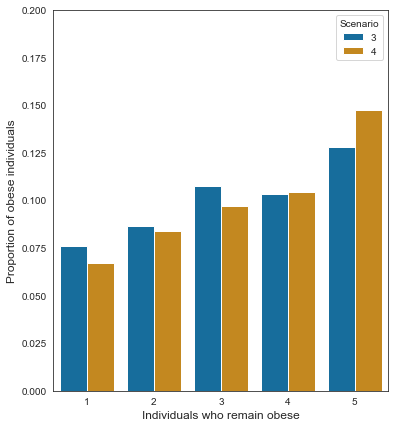

In [126]:
# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(6, 7))
ax = sns.barplot(
    x="IMD_q",
    y="prop_remain",
    hue="Scenario",
    data=remain_obese_imd_compare,
    palette="colorblind",
)
ax.set_ylim(0, 0.2)

ax.set_xlabel("Individuals who remain obese", fontsize=12)
ax.set_ylabel("Proportion of obese individuals", fontsize=12)

In [127]:
remain_obese_imd_compare2 = pd.concat([remain_obese_imd, remain_obese_imd2], axis =1)

In [128]:
remain_obese_imd_compare2 = remain_obese_imd.merge(remain_obese_imd2, 
                                                   left_on = ['IMD_q', 'BMI_class', 'final_BMI_class'],
                                                  right_on = ['IMD_q', 'BMI_class', 'final_BMI_class'],
                                                  suffixes = ['_sc3', '_sc4'])

In [129]:
remain_obese_imd_compare2['diff'] = remain_obese_imd_compare2['prop_remain_sc3'] - remain_obese_imd_compare2['prop_remain_sc4']

In [130]:
remain_obese_imd_compare2

,IMD_q,BMI_class,final_BMI_class,Count_sc3,group_size_sc3,prop_remain_sc3,Scenario_sc3,Count_sc4,group_size_sc4,prop_remain_sc4,Scenario_sc4,diff
0,1,obese,obese,179,2353,0.076073,3,158,2353,0.067148,4,0.008925
1,2,obese,obese,204,2353,0.086698,3,198,2353,0.084148,4,0.002550
2,3,obese,obese,253,2353,0.107522,3,228,2353,0.096898,4,0.010625
3,4,obese,obese,243,2353,0.103272,3,246,2353,0.104547,4,-0.001275
4,5,obese,obese,302,2353,0.128347,3,347,2353,0.147471,4,-0.019125


In [131]:
# Sex
groupby_args = ['Sex', 'BMI_class', 'final_BMI_class']
new_df = sc3.groupby(groupby_args).size().reset_index()
new_df.columns = groupby_args + ['Count']

remain_obese_sex = new_df[(new_df['BMI_class'] == 'obese') & (new_df['final_BMI_class'] == 'obese')]
remain_obese_sex['group_size'] = 2353
# remain_obese_sex['group_size'] = remain_obese_sex['Sex'].apply(lambda x: group_sizes['Sex'][x])

remain_obese_sex['prop_remain'] = remain_obese_sex['Count']/remain_obese_sex['group_size']

remain_obese_sex['Scenario'] = '3'

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/2516421013.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_sex['group_size'] = 2353
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/2516421013.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_sex['prop_remain'] = remain_obese_sex['Count']/remain_obese_sex['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/2516421013.py:12: SettingWithCopyWarning: 
A value is trying 

In [132]:
groupby_args = ['Sex', 'BMI_class', 'final_BMI_class']
new_df = sc4.groupby(groupby_args).size().reset_index()
new_df.columns = groupby_args + ['Count']

remain_obese_sex2 = new_df[(new_df['BMI_class'] == 'obese') & (new_df['final_BMI_class'] == 'obese')]
remain_obese_sex2['group_size'] = 2353
# remain_obese_sex2['group_size'] = remain_obese_sex2['Sex'].apply(lambda x: group_sizes['Sex'][x])

remain_obese_sex2['prop_remain'] = remain_obese_sex2['Count']/remain_obese_sex2['group_size']

remain_obese_sex2['Scenario'] = '4'

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/3957392378.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_sex2['group_size'] = 2353
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/3957392378.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_sex2['prop_remain'] = remain_obese_sex2['Count']/remain_obese_sex2['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/3957392378.py:11: SettingWithCopyWarning: 
A value is tryi

In [133]:
remain_obese_sex_compare = pd.concat([remain_obese_sex, remain_obese_sex2])

Text(0, 0.5, 'Proportion of obese individuals')

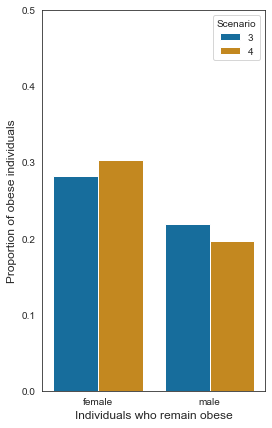

In [134]:
# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(4, 7))
ax = sns.barplot(
    x="Sex",
    y="prop_remain",
    hue="Scenario",
    data=remain_obese_sex_compare,
    palette="colorblind",
)
ax.set_ylim(0, 0.5)

ax.set_xlabel("Individuals who remain obese", fontsize=12)
ax.set_ylabel("Proportion of obese individuals", fontsize=12)

In [135]:
remain_obese_sex_compare

,Sex,BMI_class,final_BMI_class,Count,group_size,prop_remain,Scenario
0,female,obese,obese,665,2353,0.282618,3
3,male,obese,obese,516,2353,0.219295,3
0,female,obese,obese,715,2353,0.303867,4
2,male,obese,obese,462,2353,0.196345,4


In [136]:
# Ethnicity
groupby_args = ['Ethnicity', 'BMI_class', 'final_BMI_class']
new_df = sc3.groupby(groupby_args).size().reset_index()
new_df.columns = groupby_args + ['Count']

remain_obese_eth = new_df[(new_df['BMI_class'] == 'obese') & (new_df['final_BMI_class'] == 'obese')]
remain_obese_eth['group_size'] = 2353

# remain_obese_eth['group_size'] = remain_obese_eth['Ethnicity'].apply(lambda x: group_sizes['Ethnicity'][x])

remain_obese_eth['prop_remain'] = remain_obese_eth['Count']/remain_obese_eth['group_size']

remain_obese_eth['Scenario'] = '3'

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1273561909.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_eth['group_size'] = 2353
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1273561909.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_eth['prop_remain'] = remain_obese_eth['Count']/remain_obese_eth['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/1273561909.py:13: SettingWithCopyWarning: 
A value is trying 

In [137]:
groupby_args = ['Ethnicity', 'BMI_class', 'final_BMI_class']
new_df = sc4.groupby(groupby_args).size().reset_index()
new_df.columns = groupby_args + ['Count']

remain_obese_eth2 = new_df[(new_df['BMI_class'] == 'obese') & (new_df['final_BMI_class'] == 'obese')]
remain_obese_eth2['group_size'] = 2353
# remain_obese_eth2['group_size'] = remain_obese_eth2['Ethnicity'].apply(lambda x: group_sizes['Ethnicity'][x])

remain_obese_eth2['prop_remain'] = remain_obese_eth2['Count']/remain_obese_eth2['group_size']

remain_obese_eth2['Scenario'] = '4'

/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/3628078301.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_eth2['group_size'] = 2353
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/3628078301.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remain_obese_eth2['prop_remain'] = remain_obese_eth2['Count']/remain_obese_eth2['group_size']
/var/folders/gf/rm1xdbpn0tb5ndx6hln94yfxxv2h7n/T/ipykernel_93461/3628078301.py:11: SettingWithCopyWarning: 
A value is tryi

In [138]:
remain_obese_eth_compare = pd.concat([remain_obese_eth, remain_obese_eth2])

Text(0, 0.5, 'Proportion of obese individuals')

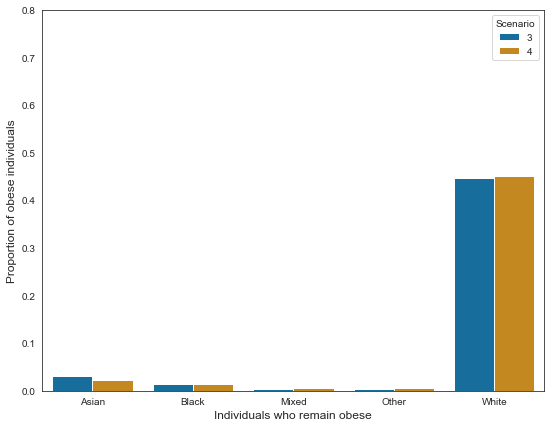

In [139]:
# Set up  matplotlib figure
fig, axs = plt.subplots(figsize=(9, 7))
ax = sns.barplot(
    x="Ethnicity",
    y="prop_remain",
    hue="Scenario",
    data=remain_obese_eth_compare,
    palette="colorblind",
)
ax.set_ylim(0, 0.8)

ax.set_xlabel("Individuals who remain obese", fontsize=12)
ax.set_ylabel("Proportion of obese individuals", fontsize=12)

In [140]:
remain_obese_eth_compare

,Ethnicity,BMI_class,final_BMI_class,Count,group_size,prop_remain,Scenario
0,Asian,obese,obese,75,2353,0.031874,3
2,Black,obese,obese,32,2353,0.013600,3
5,Mixed,obese,obese,11,2353,0.004675,3
7,Other,obese,obese,9,2353,0.003825,3
10,White,obese,obese,1054,2353,0.447939,3
0,Asian,obese,obese,53,2353,0.022524,4
2,Black,obese,obese,35,2353,0.014875,4
4,Mixed,obese,obese,13,2353,0.005525,4
6,Other,obese,obese,14,2353,0.005950,4
8,White,obese,obese,1062,2353,0.451339,4


In [141]:
remain_obese_eth_compare2 = remain_obese_eth.merge(remain_obese_eth2, 
                                                   left_on = ['Ethnicity', 'BMI_class', 'final_BMI_class'],
                                                  right_on = ['Ethnicity', 'BMI_class', 'final_BMI_class'],
                                                  suffixes = ['_sc3', '_sc4'])

In [142]:
remain_obese_eth_compare2['diff'] = remain_obese_eth_compare2['prop_remain_sc3'] - remain_obese_eth_compare2['prop_remain_sc4']

In [143]:
remain_obese_eth_compare2

,Ethnicity,BMI_class,final_BMI_class,Count_sc3,group_size_sc3,prop_remain_sc3,Scenario_sc3,Count_sc4,group_size_sc4,prop_remain_sc4,Scenario_sc4,diff
0,Asian,obese,obese,75,2353,0.031874,3,53,2353,0.022524,4,0.009350
1,Black,obese,obese,32,2353,0.013600,3,35,2353,0.014875,4,-0.001275
2,Mixed,obese,obese,11,2353,0.004675,3,13,2353,0.005525,4,-0.000850
3,Other,obese,obese,9,2353,0.003825,3,14,2353,0.005950,4,-0.002125
4,White,obese,obese,1054,2353,0.447939,3,1062,2353,0.451339,4,-0.003400
